In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carrega a tabela imortação
imp_fert=pd.read_csv('~/git/BD/temp/imp_fert1.csv')

# Carrega a tabela com características adicionais de cada NCM
ncm_e=pd.read_csv('~/git/BD/Comexstat/tab_complementares/ncm_e.csv')

# Insere a data
imp_fert.insert(0,'date',pd.to_datetime(imp_fert.CO_ANO.astype(str)+'/'+imp_fert.CO_MES.astype(str)+'/1'))

# Funde as tabelas
imp_fert=ncm_e.merge(imp_fert)

# Ranqueia a seleciona os 1 maiores NCMs em peso
imp_fert_top=imp_fert.groupby('CO_NCM').KG_LIQUIDO.sum().sort_values(ascending=False).reset_index().head(10)['CO_NCM'].values

# Filtra a tabela deixano passar somente os registros dos NCMs top
imp_fert=imp_fert[imp_fert.CO_NCM.isin(imp_fert_top)]

In [2]:
title='Importação de Fertilizantes'

Por Peso


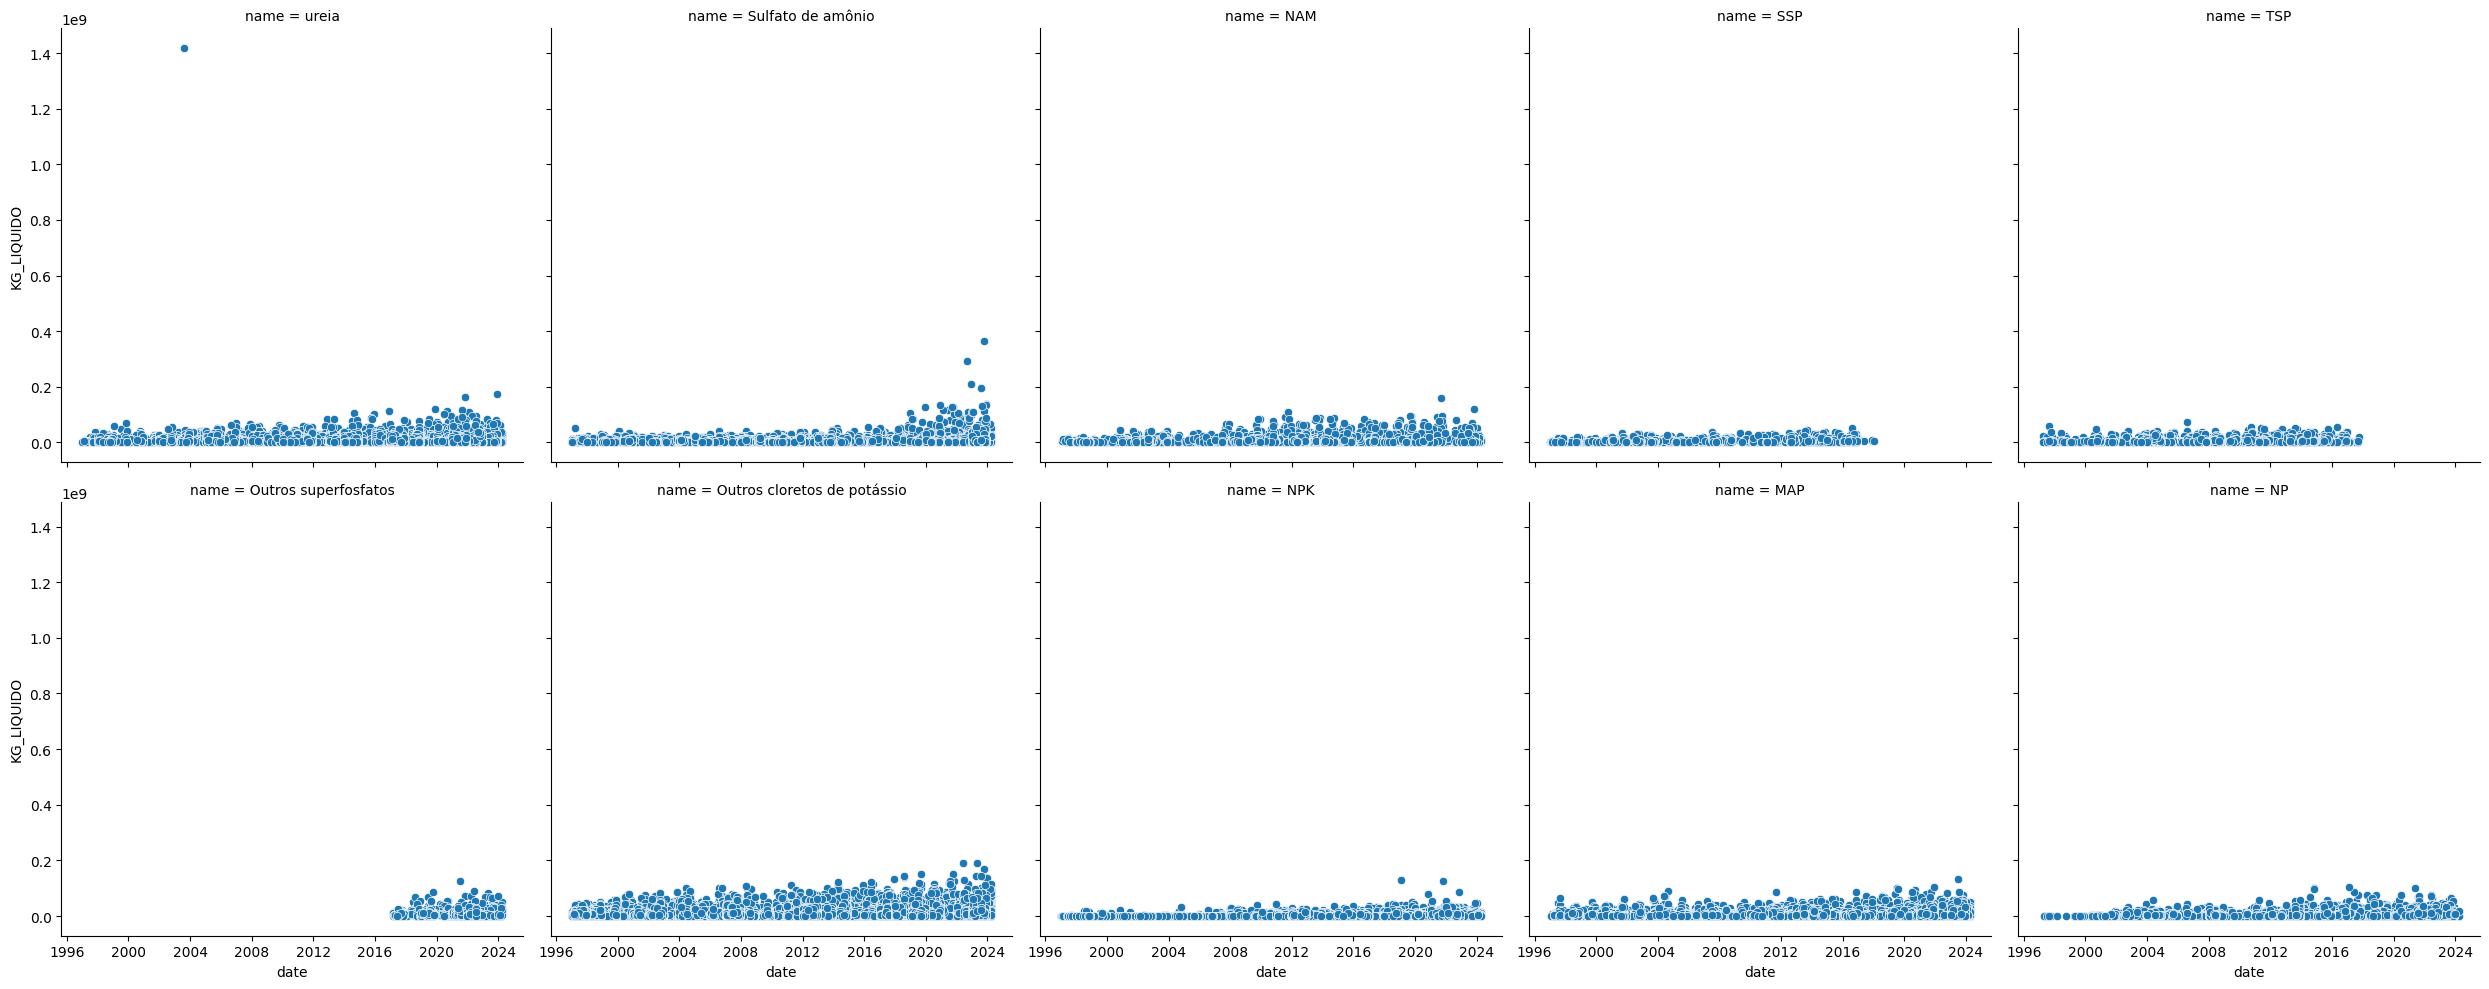

Por Valor


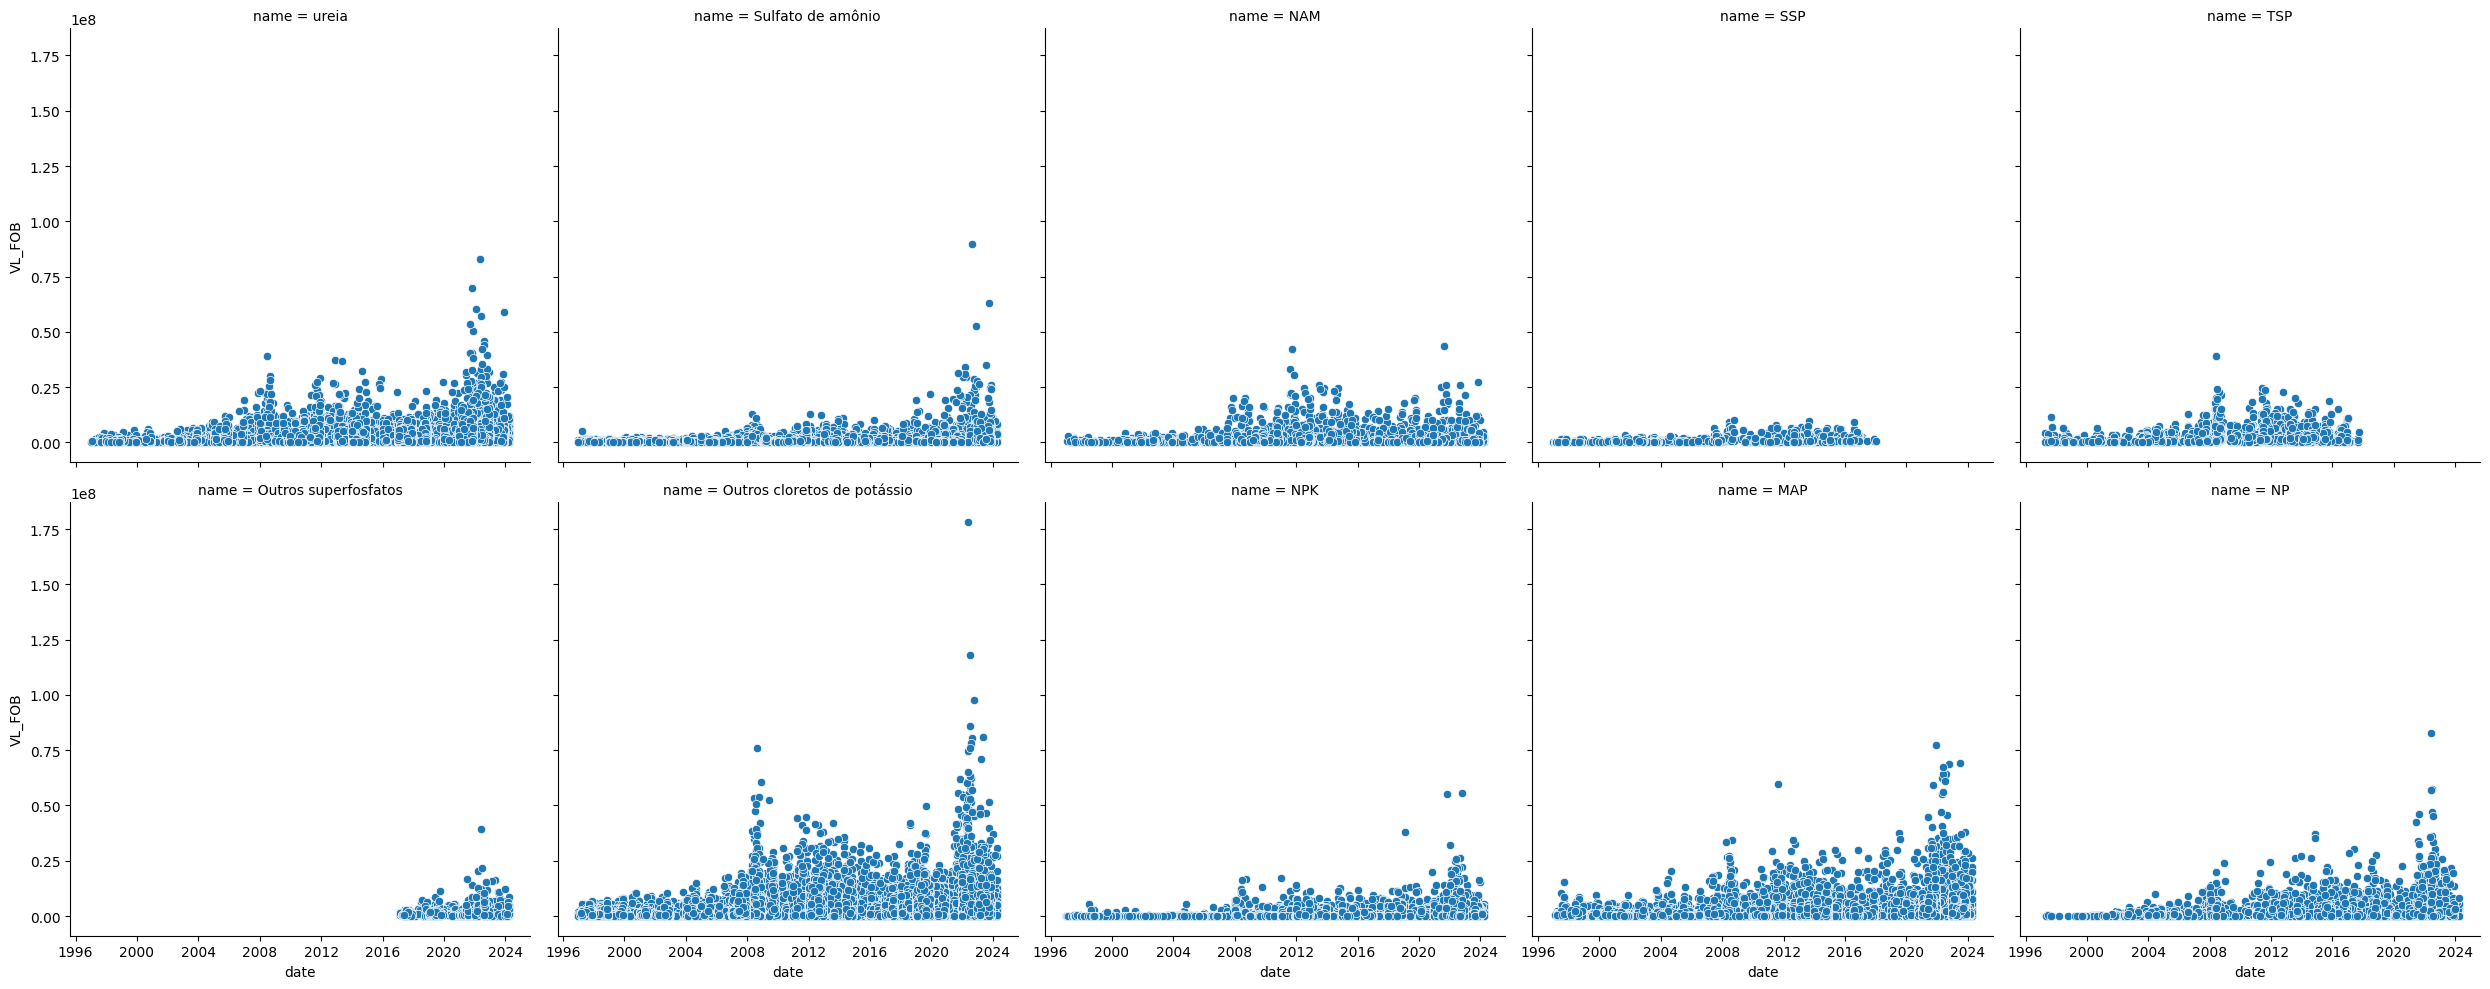

In [3]:
# Visualiza cronologicamenete os pesos por NCM
print('Por Peso')
sns.relplot(data=imp_fert.sort_values('CO_NCM'),x='date',y='KG_LIQUIDO', col='name', col_wrap=5)#.fig.suptitle(name,y=1.1)
plt.show()

# Visualiza cronologicamenete os valores por NCM
print('Por Valor')
sns.relplot(data=imp_fert.sort_values('CO_NCM'),x='date',y='VL_FOB', col='name', col_wrap=5)#.fig.suptitle(name,y=1.1)
plt.show()

In [4]:
# Funde NCMs de diversos Superfosfatos
imp_fert.loc[imp_fert.name=='SSP','CO_NCM']=31031900
imp_fert.loc[imp_fert.name=='TSP','CO_NCM']=31031900

In [5]:
# Funde NCMs de diversos Superfosfatos
imp_fert.loc[imp_fert.name=='SSP','name']='Outros superfosfatos'
imp_fert.loc[imp_fert.name=='TSP','name']='Outros superfosfatos'

In [6]:
# Reagrupa todas as colunas categoricas que estavam em duplicidade depois da fundição dos NCMs
imp_fert=imp_fert.groupby(by=imp_fert.columns[:12].tolist())[imp_fert.columns[12:]].sum().reset_index()

In [7]:
imp_fert_err=imp_fert[imp_fert.KG_LIQUIDO==imp_fert.KG_LIQUIDO.max()]

imp_fert_correto=imp_fert[imp_fert.KG_LIQUIDO!=imp_fert.KG_LIQUIDO.max()]

data_prdt_err=imp_fert_err[['date','CO_NCM']]

imp_fert_correto_data_err=imp_fert_correto.merge(data_prdt_err)

imp_fert_correto_data_err=imp_fert_correto_data_err.groupby('CO_NCM')[['VL_FOB','KG_LIQUIDO']].sum()

imp_fert_correto_data_err=imp_fert_correto_data_err.assign(preço=imp_fert_correto_data_err.VL_FOB / imp_fert_correto_data_err.KG_LIQUIDO)
imp_fert_correto_data_err

preço_correção=imp_fert_correto_data_err.preço.values[0]

imp_fert_err.loc[:,'KG_LIQUIDO']=round(imp_fert_err.VL_FOB / preço_correção).astype(int)

imp_fert_err.columns

imp_fert=pd.concat([imp_fert_err,imp_fert_correto])

In [8]:
# Confere existência de duplicatas
print(f"Exitem {imp_fert.loc[:,:'CO_URF'].duplicated().sum()} duplicatas das colunas categóricas")

Exitem 0 duplicatas das colunas categóricas


In [9]:
# Confere existência de nan
print(f"Exitem {imp_fert.isna().sum().sum()} NANs nos registros")

Exitem 0 NANs nos registros


In [10]:
# Corrige inflação monetária

# Cria manualmente a tabela de correção do dólar
infl_dolar=pd.DataFrame({
 'CO_ANO':np.arange(1997,2025),
 'FATOR':[0.50,0.50,0.51,0.53,0.55,0.56,0.57,0.59,0.61,\
 0.63,0.64,0.67,0.67,0.68,0.70,0.72,0.73,0.74,\
 0.74,0.75,0.77,0.78,0.80,0.81,0.85,0.92,0.96,1.00]})

imp_fert=imp_fert.merge(infl_dolar)

#Armazena valor histórico em nova coluna
imp_fert['VL_FOB_corr']=imp_fert['VL_FOB']

# Atualiza valor monetário
imp_fert['VL_FOB_corr']=imp_fert['VL_FOB_corr']/imp_fert['FATOR']

imp_fert=imp_fert.rename(columns={'VL_FOB':'VL_FOB_hist','VL_FOB_corr':'VL_FOB'})

imp_fert=imp_fert.assign(date=pd.to_datetime(imp_fert.CO_ANO.astype(str)+'/'+imp_fert.CO_MES.astype(str)+'/1'))

In [11]:
imp_fert_l=pd.concat([imp_fert[['CO_NCM','date','VL_FOB']].assign(tipo='corrgido'),imp_fert[['CO_NCM','date','VL_FOB_hist']]\
                     .rename(columns={'VL_FOB_hist':'VL_FOB'}).assign(tipo='histórico')])
#imp_fert_l.date=imp_fert_l.date.astype(int)

imp_fert_l=imp_fert_l.sort_values('tipo',ascending=False)

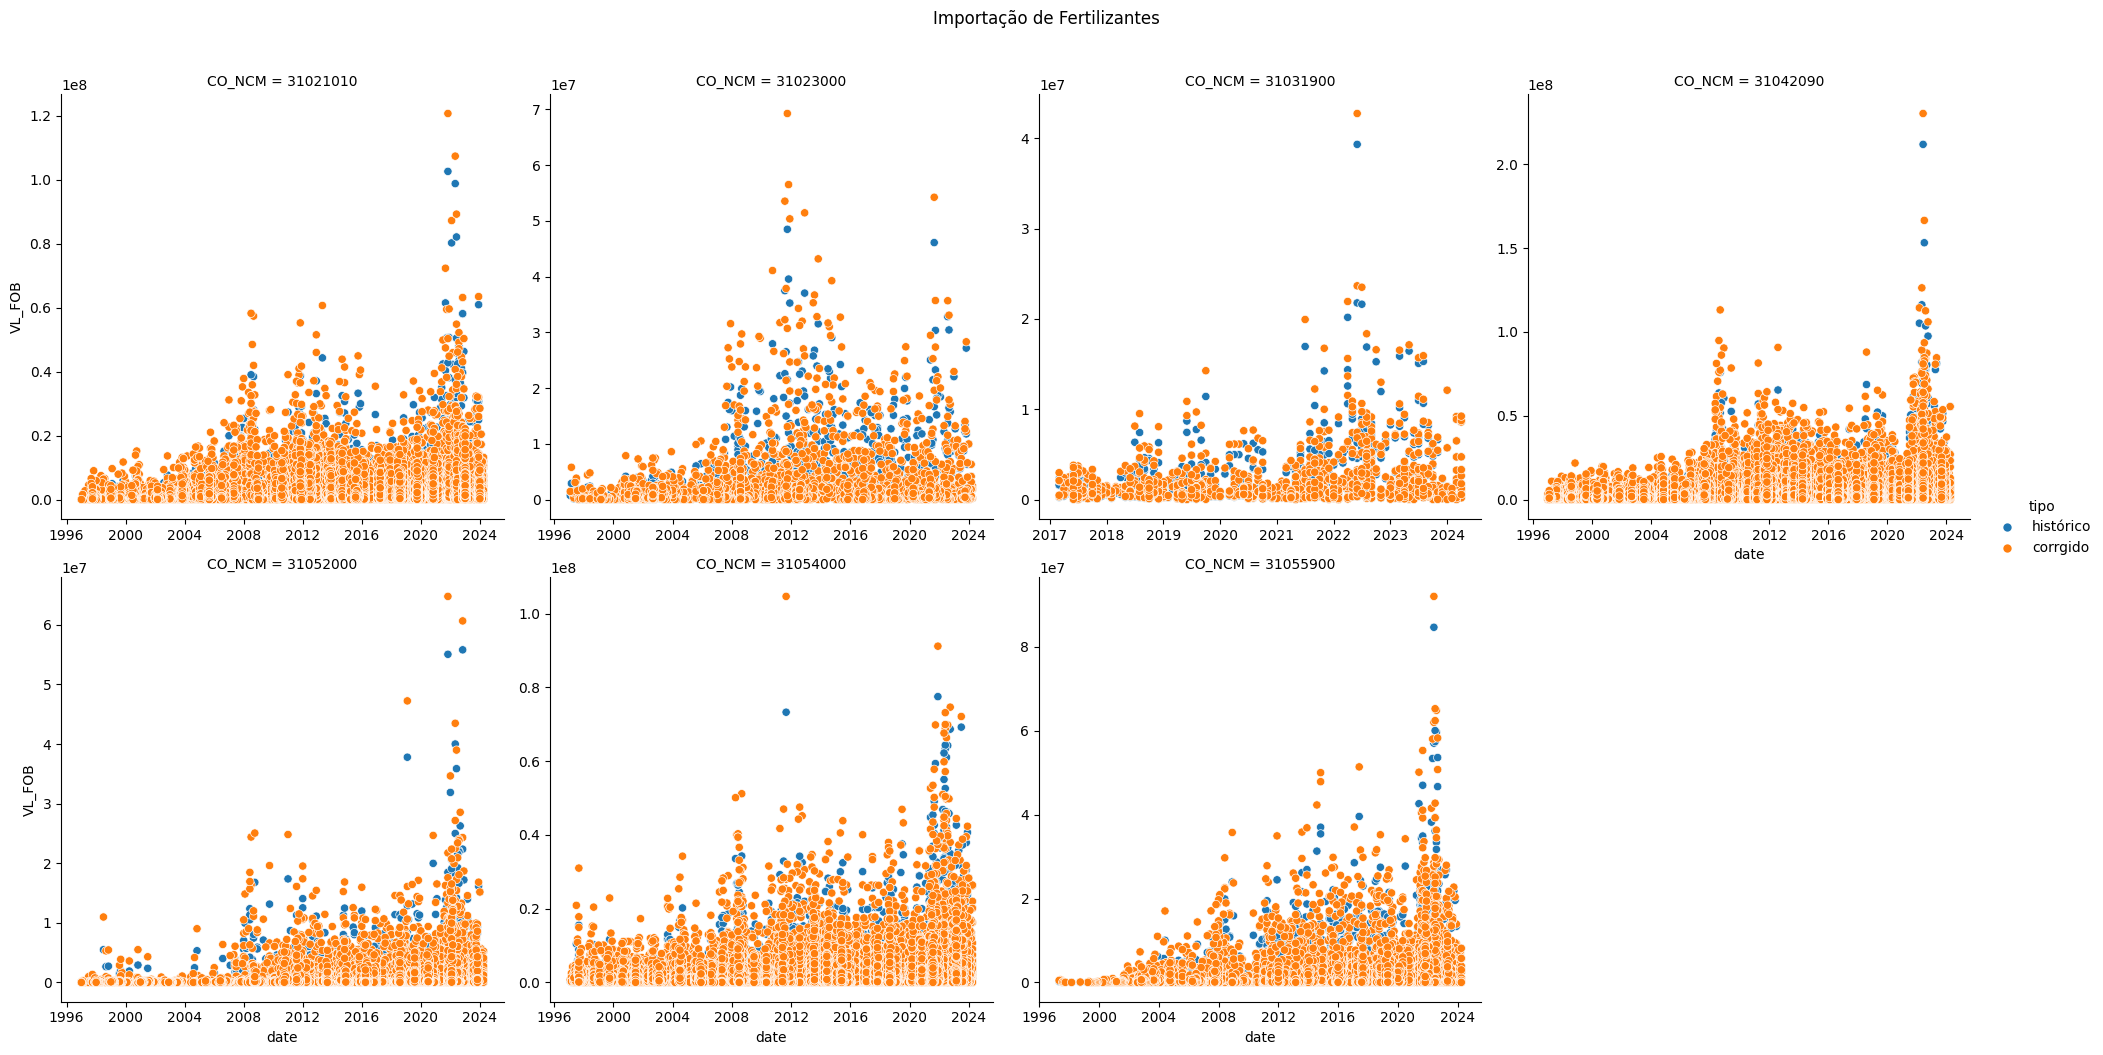

In [12]:
sns.relplot(data=imp_fert_l,x='date',y='VL_FOB',hue='tipo',col='CO_NCM',col_wrap=4, facet_kws=dict(sharex=False,sharey=False)).fig.suptitle(title,y=1.05)
plt.show()

In [13]:
# %  de valor em registros com peso igual a zero
print(f"Valor contido nos registros com peso igual a zero corresponde a {round(100 * imp_fert[imp_fert.KG_LIQUIDO==0].VL_FOB.sum() / imp_fert.VL_FOB.sum())} % do total.")

Valor contido nos registros com peso igual a zero corresponde a 0 % do total.


In [14]:
# Descarta peso igual a zero
imp_fert=imp_fert[imp_fert.KG_LIQUIDO!=0]

In [15]:
# %  de peso em registros com valor igual a zero
print(f"Peso contido nos registros com valor igual a zero corresponde a {round(100 * imp_fert[imp_fert.VL_FOB==0].KG_LIQUIDO.sum() / imp_fert.KG_LIQUIDO.sum())} % do total.")

Peso contido nos registros com valor igual a zero corresponde a 0 % do total.


In [16]:
# Descarta valor igual a zero
imp_fert=imp_fert[imp_fert.VL_FOB!=0]

In [17]:
# Verifica participação das vias no peso total importado
rank_vias=imp_fert.groupby('CO_VIA').KG_LIQUIDO.sum().sort_values(ascending=False).reset_index()

In [18]:
# Identifica a via líder em movimentação 
via=pd.read_csv('~/git/BD/Comexstat/tab_complementares/VIA.csv',encoding='Latin-1',sep=';')
print(f"A via amplamente líder é a via {via[via.CO_VIA==rank_vias.CO_VIA.values[0]].NO_VIA.values[0]}, código {via[via.CO_VIA==rank_vias.CO_VIA.values[0]].CO_VIA.values[0]}. As demais serão descartadas.")

A via amplamente líder é a via MARITIMA, código 1. As demais serão descartadas.


In [19]:
rank_vias=rank_vias.assign(kg_acml=rank_vias.KG_LIQUIDO.rolling(len(rank_vias),min_periods=1).sum())
print(f"A via principal corresponde a {rank_vias.assign(kg_perc=round(rank_vias.kg_acml/rank_vias.KG_LIQUIDO.sum()*100)).kg_perc[0]}% da exportação agricola total.")

A via principal corresponde a 100.0% da exportação agricola total.


In [20]:
# Filtra deixando passar somente  a via 1
imp_fert=imp_fert[imp_fert.CO_VIA==1]

In [21]:
# Descarta as colunas como previsto
imp_fert.drop(columns=['CO_VIA','CO_UNID','QT_ESTAT','FATOR'],inplace=True)

# NCM

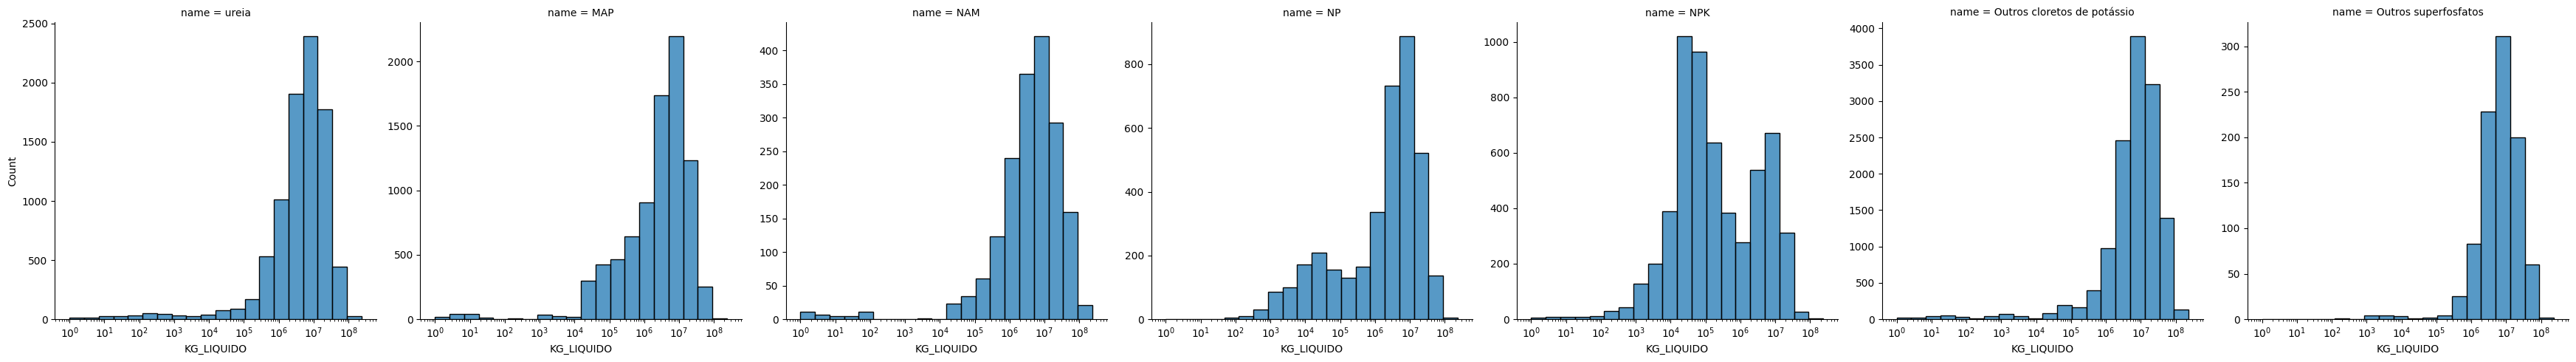

In [22]:
# Distribuição do peso dos registros de importação por NCM
sns.displot(data=imp_fert,x='KG_LIQUIDO',log_scale=True,col='name', bins=20, facet_kws={'sharex':False, 'sharey':False})

### Clusterização pelo preço

In [23]:
# Determina o preço praticado em cada registro
imp_fert=imp_fert.assign(fob_kg=imp_fert.VL_FOB/imp_fert.KG_LIQUIDO)

Reescalona os preços para uma mesma escala, de 0 a 1, exigido para o bom funcionamento do algoritmo a ser utilizado.

In [24]:
from sklearn.preprocessing import MinMaxScaler as MMS
MMS=MMS()
sc=pd.DataFrame(MMS.fit_transform(imp_fert[['fob_kg']]), columns=['fob_kg_s'])

imp_fert=pd.concat([imp_fert.reset_index(drop=True),sc],axis=1)

In [25]:
imp_fert=imp_fert.sort_values(by=['CO_NCM','KG_LIQUIDO'], ascending=False)

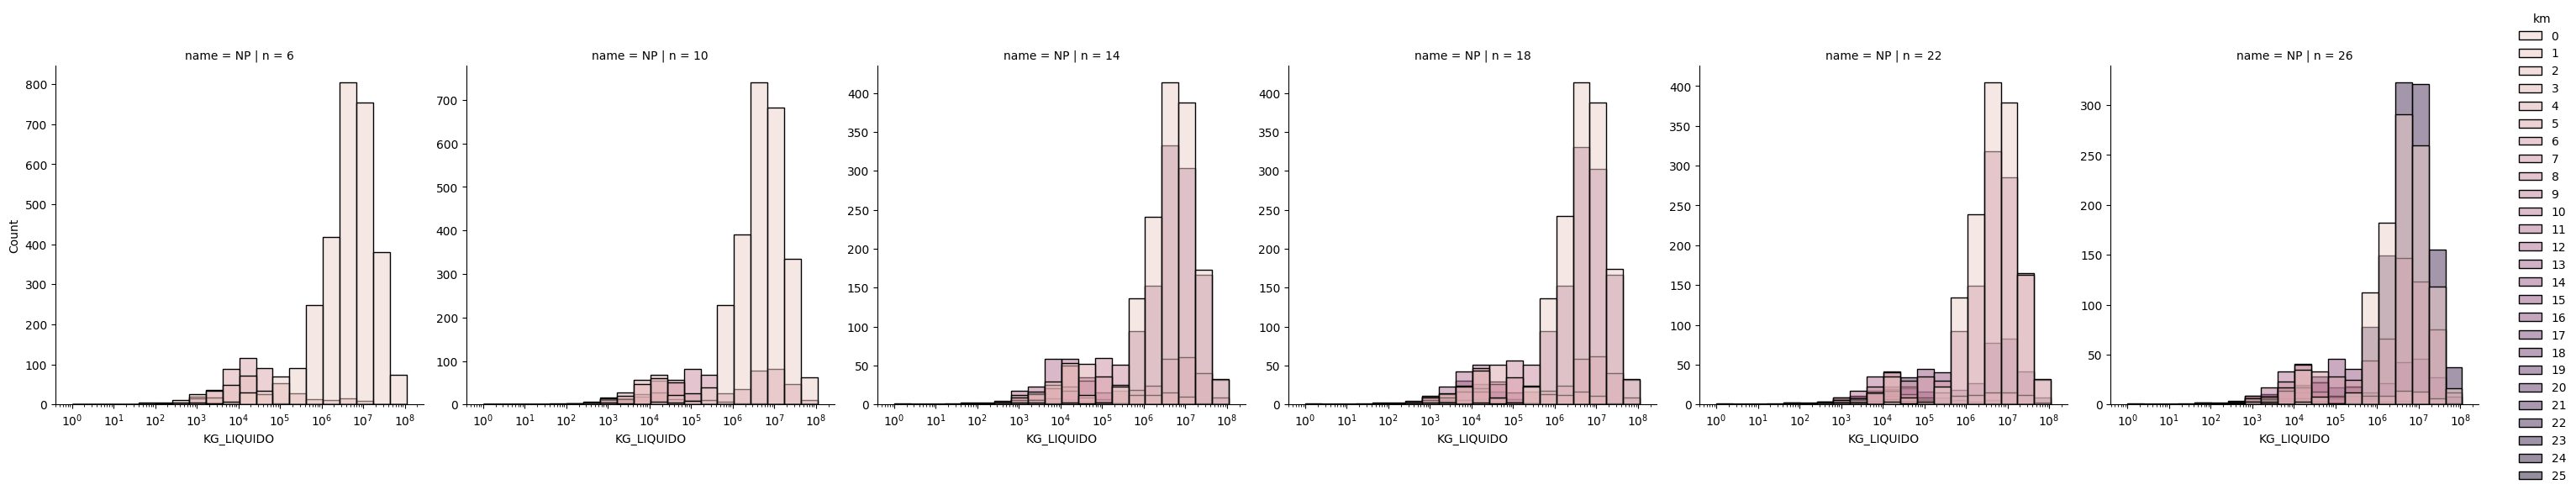

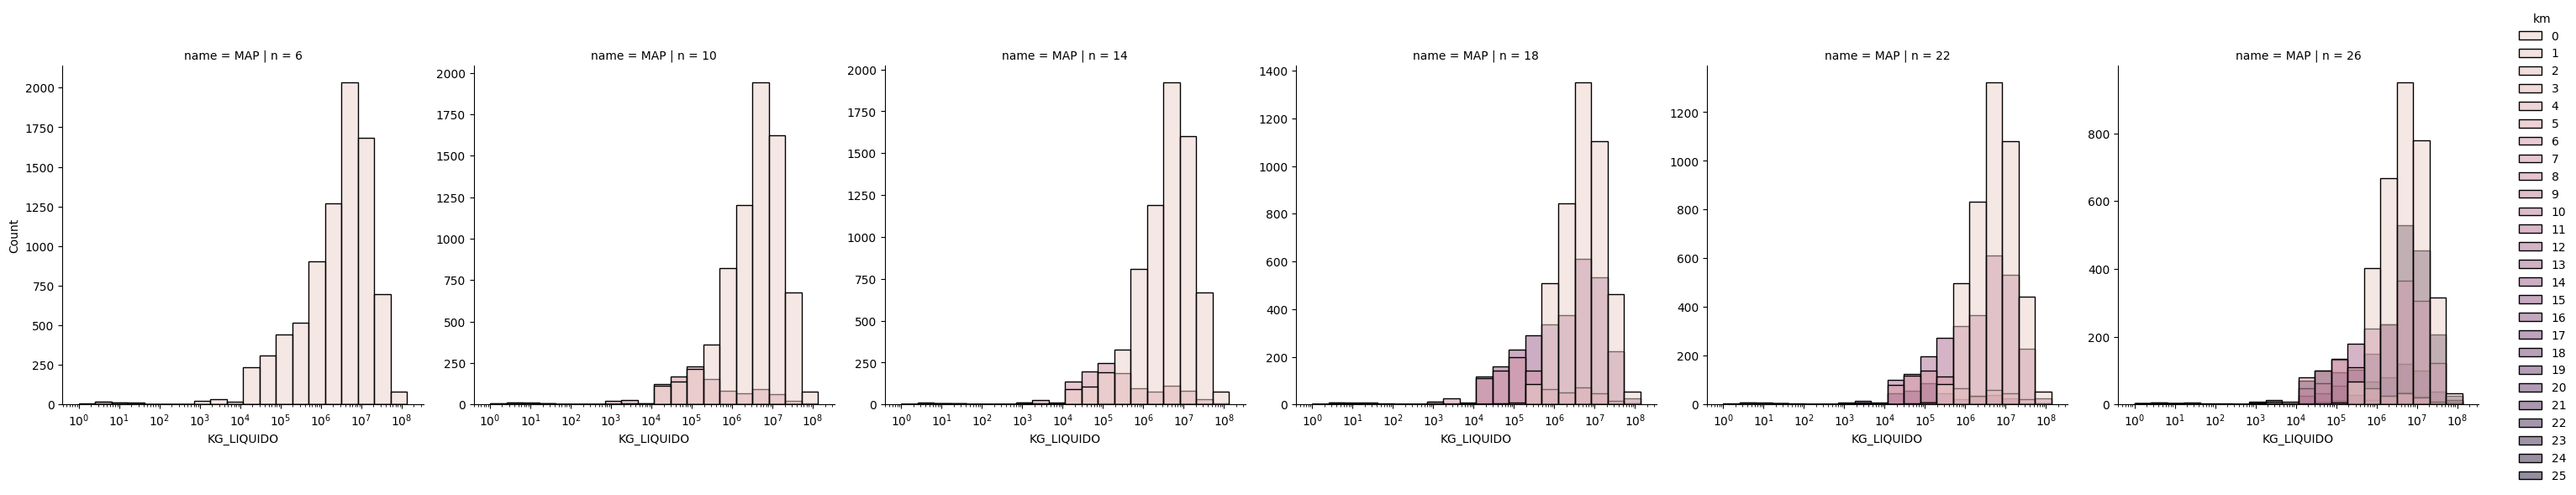

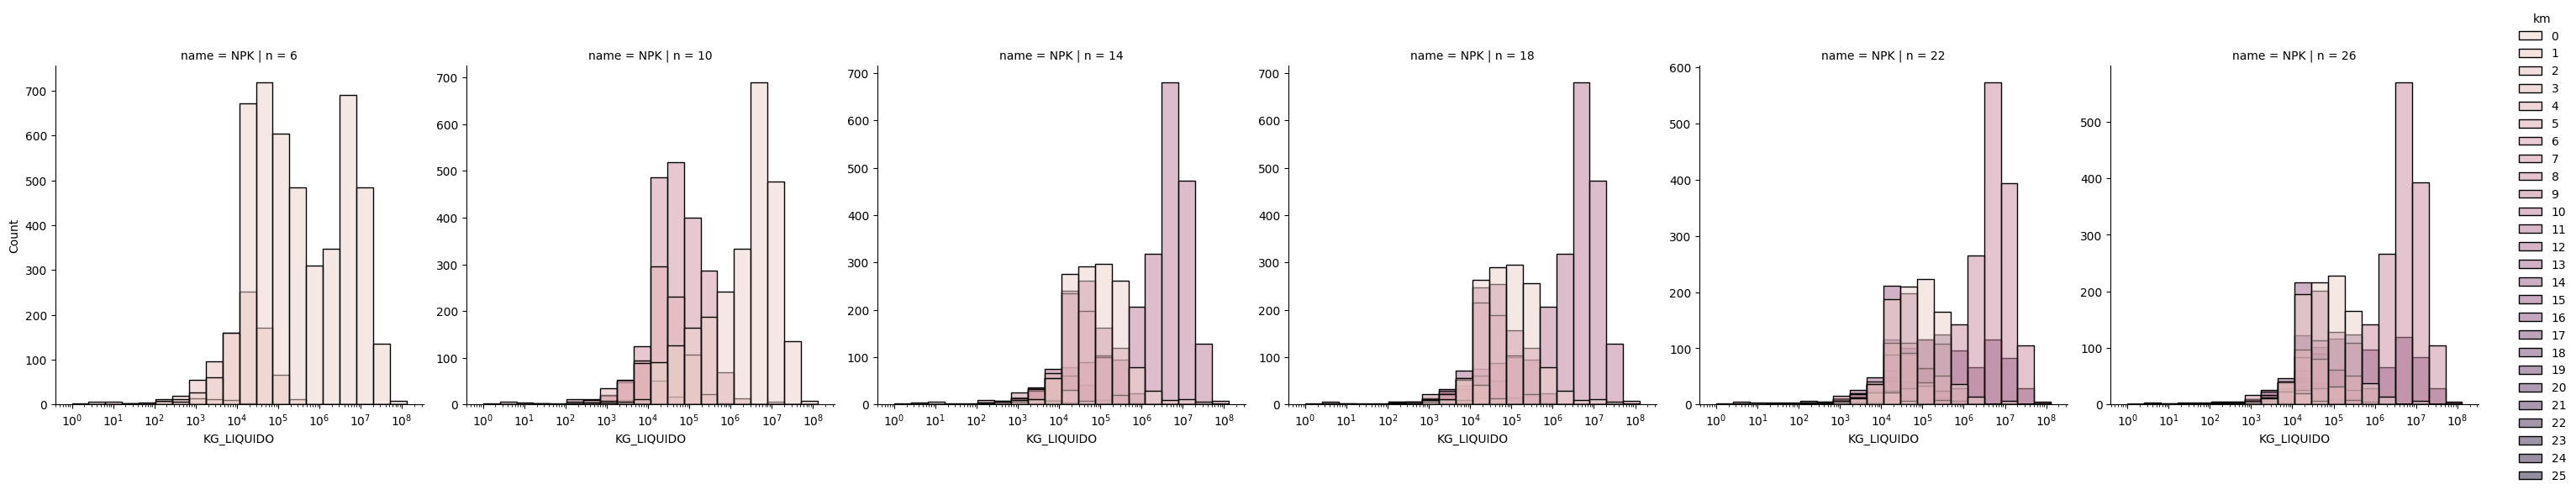

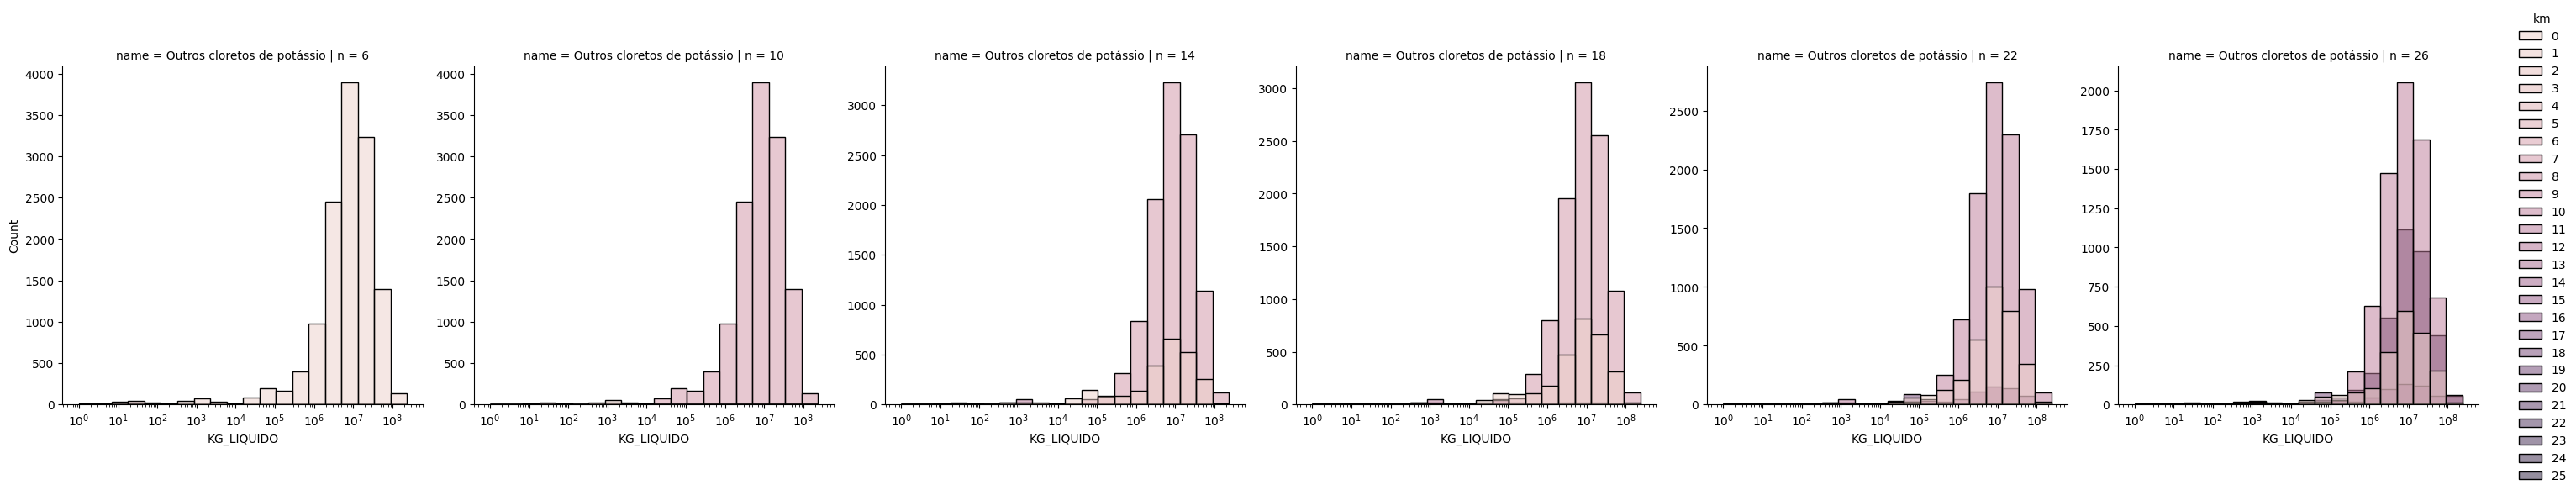

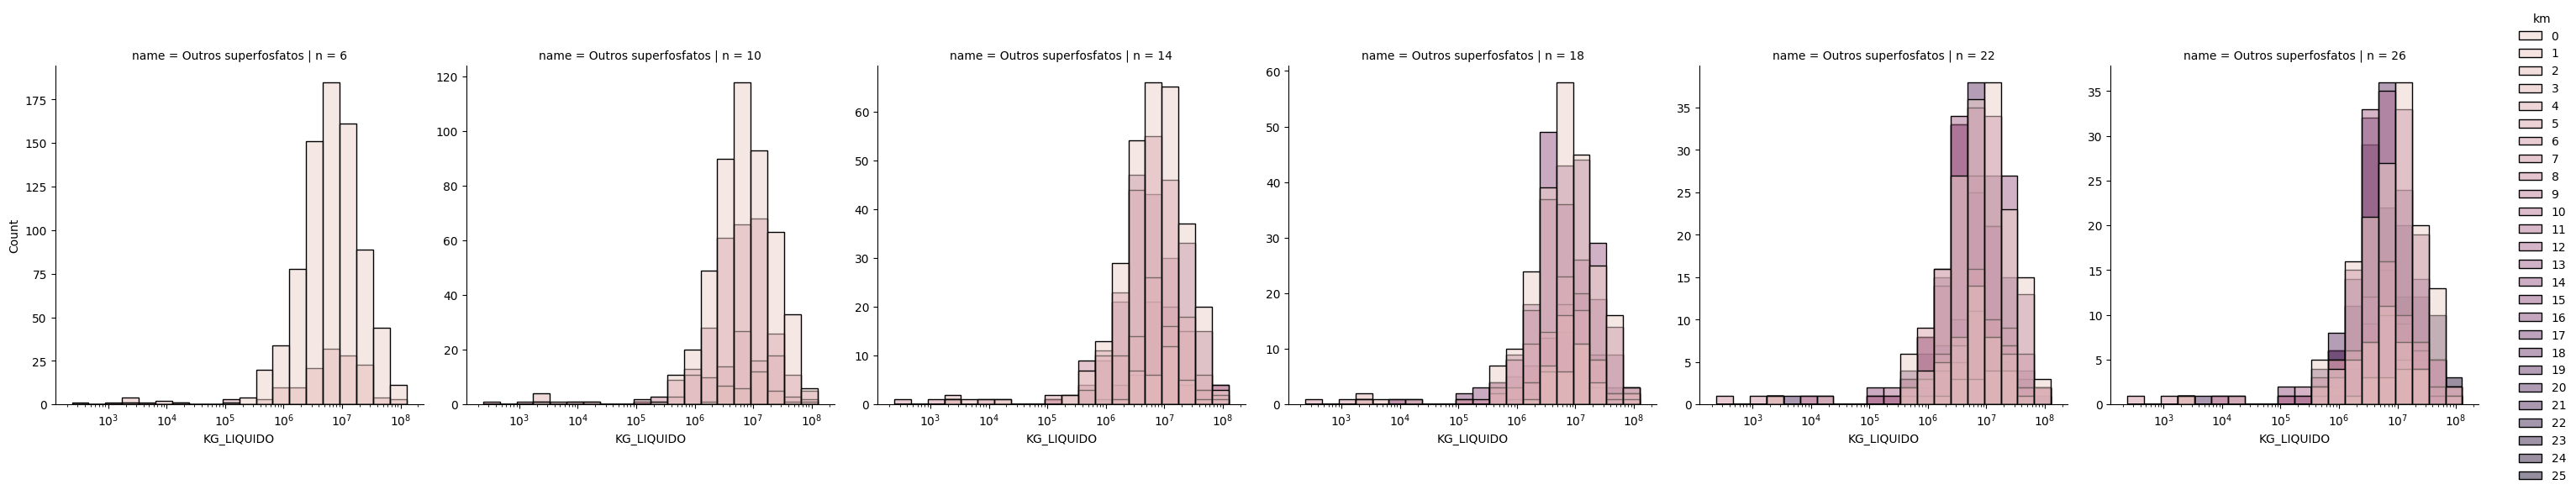

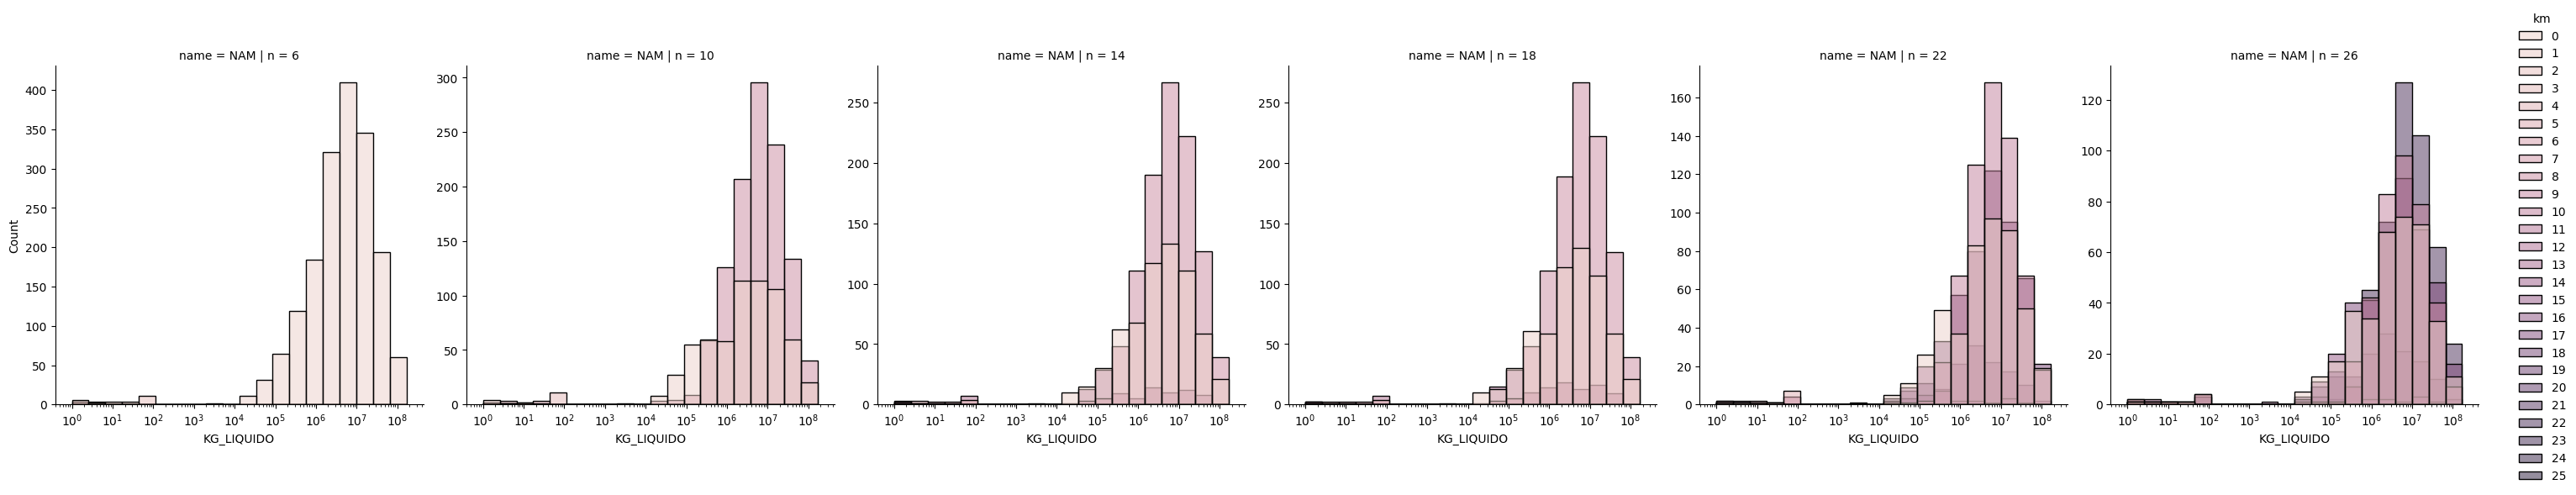

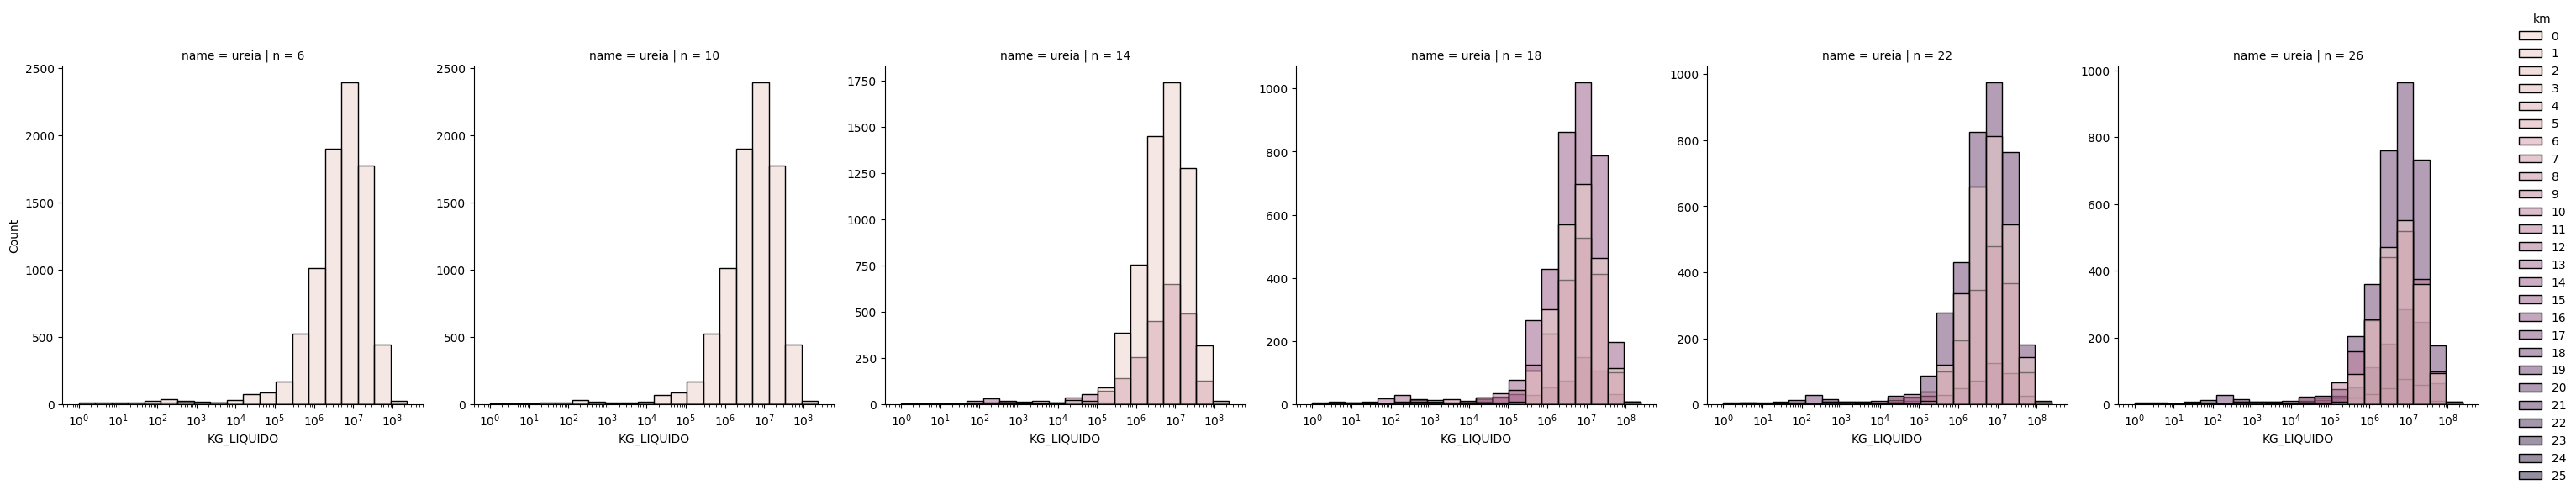

In [26]:
# Clusteriza pelo preço

r=pd.DataFrame()
for name in imp_fert.name.unique():
    q=pd.DataFrame()
    for n in range(6,30,4):
        from sklearn.cluster import KMeans as KM
        KM=KM(n_clusters=n, n_init='auto', random_state=1)
    
        imp_fert_name=imp_fert[imp_fert.name==name]
        imp_fert_name_km=imp_fert_name.assign(km=KM.fit_predict(imp_fert_name[['fob_kg_s']])).assign(n=n)
        q=pd.concat([q,imp_fert_name_km])

    
    sns.displot(
        data=q,x='KG_LIQUIDO',log_scale=True, row='name',col='n', hue='km', bins=20, facet_kws={'sharex':False, 'sharey':False}
    )
    plt.show()

    r=pd.concat([r,q])

# retoma o nome da tabela
imp_fert_km=r


In [27]:
km_sel=pd.DataFrame({'name':['NP','MAP','NPK','Outros cloretos de potássio','Outros superfosfatos','NAM','SAM','ureia'],
             'n':[6,22,22,26,6,18,26,18]})

In [28]:
imp_fert_km_sel=imp_fert_km.merge(km_sel)

In [29]:
rank_correto=imp_fert_km_sel.groupby(by=['name','km']).KG_LIQUIDO.sum().reset_index().sort_values(by=['name','KG_LIQUIDO'],ascending=False)
rank_correto=rank_correto.groupby(by=['name']).KG_LIQUIDO.max().reset_index().merge(rank_correto)

In [30]:
imp_fert_km_sel_correto=imp_fert_km_sel.merge(rank_correto[['name','km']])

In [31]:
imp_fert_km_sel_erro=imp_fert_km_sel[~imp_fert_km_sel.index.isin(imp_fert_km_sel_correto.index)]

In [32]:
len(imp_fert_km_sel_erro)/len(imp_fert_km_sel_correto)*100

100.03300796906683

In [33]:
imp_fert_km_sel_erro.KG_LIQUIDO.sum()/imp_fert_km_sel_correto.KG_LIQUIDO.sum()*100

76.10701570245934

In [34]:
imp_fert_km_sel_erro.VL_FOB.sum()/imp_fert_km_sel_correto.VL_FOB.sum()*100

86.67977102404969

In [35]:
imp_fert_km_sel_erro=imp_fert_km_sel_erro.assign(erro_kg=0)
imp_fert_km_sel_erro.loc[imp_fert_km_sel_erro.KG_LIQUIDO<10**3.1,'erro_kg']=1

In [36]:
imp_fert_km_sel_erro=imp_fert_km_sel_erro.assign(erro_vl=0)
imp_fert_km_sel_erro.loc[imp_fert_km_sel_erro.VL_FOB<10**3.2,'erro_vl']=1

In [37]:
imp_fert_km_sel_erro=imp_fert_km_sel_erro.assign(descarte=0)
imp_fert_km_sel_erro.loc[(imp_fert_km_sel_erro.erro_kg==1)&(imp_fert_km_sel_erro.erro_vl==1),'descarte']=1

In [38]:
imp_fert_km_sel_erro_limpo=imp_fert_km_sel_erro[imp_fert_km_sel_erro.descarte==0].drop(columns='descarte')

In [39]:
len(imp_fert_km_sel_erro_limpo)/len(imp_fert_km_sel)*100

49.07946535913816

In [40]:
imp_fert_km_sel_erro_limpo.KG_LIQUIDO.sum()/imp_fert_km_sel.KG_LIQUIDO.sum()*100

43.06256057363763

In [41]:
imp_fert_km_sel_erro_limpo.VL_FOB.sum()/imp_fert_km_sel.VL_FOB.sum()*100

38.273748253171625

In [42]:
len(imp_fert_km_sel_correto)/len(imp_fert_km_sel)*100

49.99174936941609

In [43]:
imp_fert_km_sel_correto.KG_LIQUIDO.sum()/imp_fert_km_sel.KG_LIQUIDO.sum()*100

56.58160568598064

In [44]:
imp_fert_km_sel_correto.VL_FOB.sum()/imp_fert_km_sel.VL_FOB.sum()*100

44.155450689326806

In [45]:
i_f_km_s_c=imp_fert_km_sel_correto

In [46]:
# Determina características dos clusters para identificação deles posteriormente
q=pd.DataFrame()
for ncm in i_f_km_s_c.CO_NCM.unique():
    i_f_km_s_c_t=i_f_km_s_c[i_f_km_s_c.CO_NCM==ncm]
    i_f_km_s_c_t=i_f_km_s_c_t.assign(média=i_f_km_s_c_t.KG_LIQUIDO.mean())
    i_f_km_s_c_t=i_f_km_s_c_t.assign(std=i_f_km_s_c_t.KG_LIQUIDO.std())
    q=pd.concat([q,i_f_km_s_c_t])
i_f_km_s_c=q

In [47]:
m_s=i_f_km_s_c[['name','média','std']].drop_duplicates()

ncm_e=ncm_e.merge(m_s,how='left')

# Salva nova tabela de ncm expandida
ncm_e.to_csv('~/git/BD/Comexstat/tab_complementares/ncm_e.csv',index=False)

In [48]:
i_f_km_s_c.to_csv('~/git/BD/temp/imp_fert2.csv',index=False)

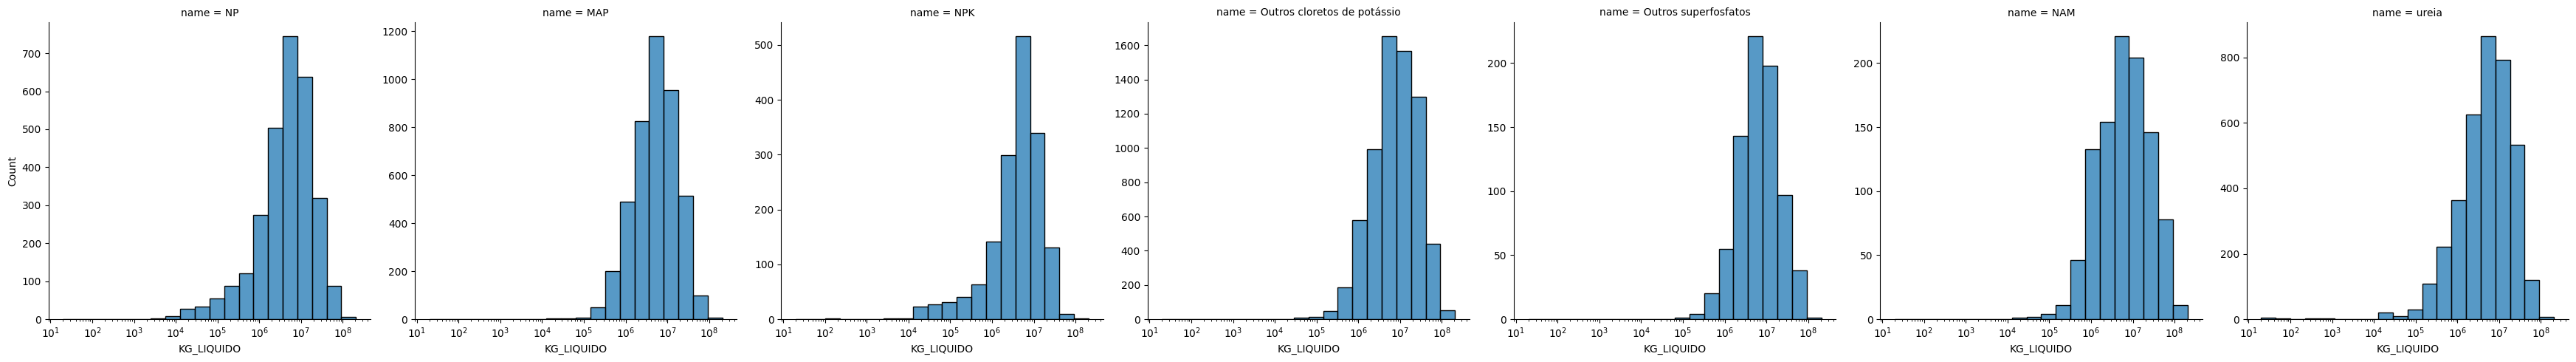

In [49]:
sns.displot(data=imp_fert_km_sel_correto,x='KG_LIQUIDO',log_scale=True,col='name', bins=20, facet_kws=dict(sharex=False, sharey=False))
plt.show()

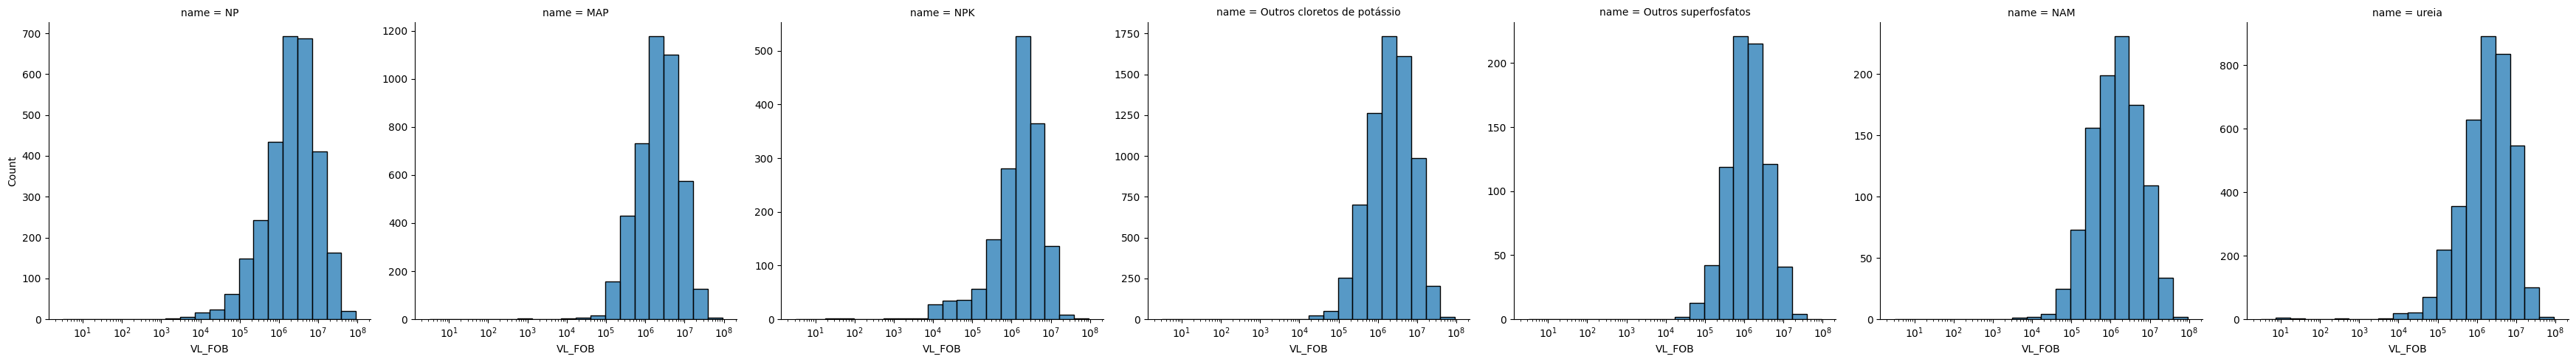

In [50]:
sns.displot(data=imp_fert_km_sel_correto,x='VL_FOB',log_scale=True,col='name', bins=20, facet_kws=dict(sharex=False, sharey=False))
plt.show()